In [2]:
import shelve

filename = "/tmp/shelve.out"
my_shelf = shelve.open(filename)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

In [103]:
# Linear scaling to [-2^n, 2^n]
a, b = -11, 77
target_bit_width = 18

range_size = b - a
b_prime = np.floor(a + range_size / 2)
a_prime = np.floor(2**(target_bit_width-1) / (max((a-b_prime), (b-b_prime)) / 2))

print(np.log2(np.abs((a-b_prime)*a_prime)), np.log2(np.abs((b-b_prime)*a_prime)))

17.999801862380863 17.999801862380863


In [104]:
Integer.that_can_represent([a-b_prime, b-b_prime]).bit_width

7

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


MINIMUM n-round: 4
##################################
ROUNDING TO: 4
##################################
acc size 8
tlu output bit width 2
jump index a [31 38 45]
step size a [7 7]
4=
acc size a 9
lsbs_a=5
a_prime=2, b_prime=2
acc size a b 9
lsbs_a_b=5
rounded values a b [16 16 16 16]


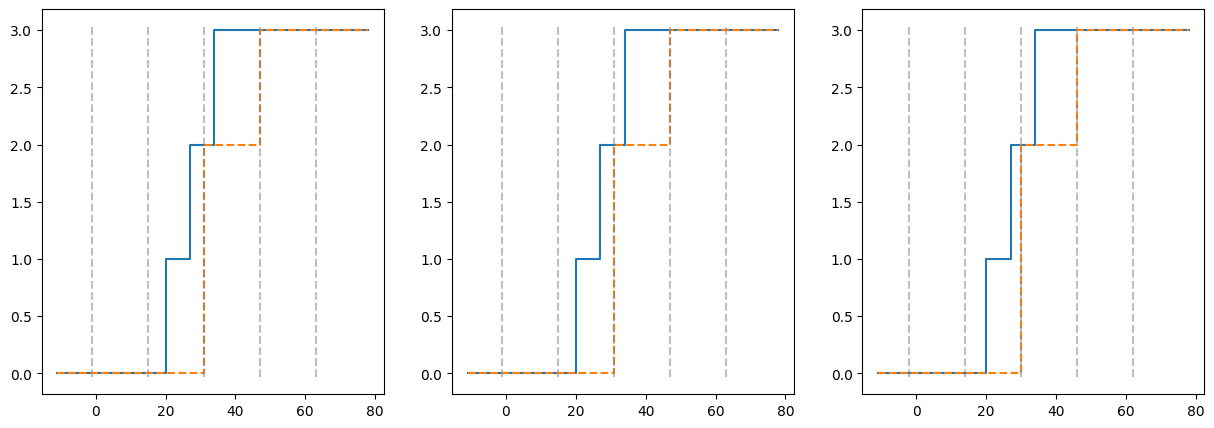

In [242]:
%reset
# Imports
from concrete.fhe import round_bit_pattern, truncate_bit_pattern
import numpy as np
from concrete.fhe.dtypes import Integer
import matplotlib.pyplot as plt

def linear_up_scaling(x: np.ndarray, a=1, b=0):
    assert x.dtype == np.int64
    assert isinstance(a, (int, np.int64)), f"{a=}, {type(a)=}"
    assert isinstance(b, (int, np.int64)), f"{b=}, {type(b)=}"
    return (x * a) + b
    
def linear_down_scaling(x:np.ndarray, a=1, b=0):
    return (x.astype(np.float64) - float(b)) / float(a)

# Hypothesis:
# * all steps are the same size
# * they aren't too many of them?

# Some parameters
# We could do a linear/binary search on the n-round-bits to use

    
# Function thresholds
step_size = 7  # Constant step size assumption
th1 = 21
th2 = th1 + step_size
th3 = th2 + step_size

# Bounds
a, b = -11, 79

rounding_threshold = int(np.ceil(np.log2((b-a)/step_size)))

print("MINIMUM n-round:", rounding_threshold)
print("##################################")
print(f"ROUNDING TO: {rounding_threshold}")
print("##################################")

# Step size function to optimize
def f(x, thresholds=(th1, th2, th3)):
    res = np.zeros_like(x)
    for threshold in thresholds:
        res += (x >= threshold).astype(np.int64)
    return res

# Inputs
x = np.arange(a, b, 1)  # Inputs
x_acc_size = Integer.that_can_represent(x).bit_width
print("acc size", x_acc_size)

# Naive rounding
lsbs = x_acc_size - rounding_threshold
x_rounded = truncate_bit_pattern(x, lsbs)

# Compute baseline
y = f(x)
y_rounded = f(x_rounded)

y_bit_width = Integer.that_can_represent(y).bit_width
print("tlu output bit width", y_bit_width)
# Plot baseline
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = axes[0]
ax.step(x, y)
ax.step(x, y_rounded, linestyle="dashed")
delta_y = y.max() - y.min()
epsilon_y = 0.01 * delta_y
ax.vlines(
    x[np.concatenate([np.diff(x_rounded).astype(bool), [False]])],
    y.min()-epsilon_y, y.max()+epsilon_y, color="grey", linestyle="dashed", alpha=.5
)

new_b = th1 + ((b - th1) // step_size ) * step_size + bool(b % step_size)*step_size
new_a = th1 - ((th1 - a) // step_size ) * step_size - bool(a % step_size)*step_size

# Find a first
jump_a = np.diff(y) > 0
jump_index_a = np.arange(0, len(jump_a))[jump_a]  # Compute where jumps are
print("jump index a", jump_index_a)
step_size_a = np.diff(jump_index_a)
assert (step_size_a == step_size).all()
print("step size a", step_size_a)
# I need random value to be such that a_prime >> 0

some_value = rounding_threshold
print(f"{some_value}=")
a_prime = np.rint((2**some_value)/(step_size_a.min())).astype(np.int64)
x_a = linear_up_scaling(x, a=a_prime)
acc_a = Integer.that_can_represent(x_a).bit_width
print("acc size a", acc_a)
lsbs_a = acc_a - rounding_threshold
print(f"{lsbs_a=}")
x_a_rounded = linear_down_scaling(truncate_bit_pattern(x_a, lsbs_a).astype(np.float64), a=float(a_prime))
y_a_rounded = f(x_a_rounded)

# Plot
ax = axes[1]
ax.step(x, y)
ax.step(x, y_a_rounded, linestyle="dashed")
ax.vlines(
    x[np.concatenate([np.diff(x_a_rounded).astype(bool), [False]])], 
    y.min()-epsilon_y, y.max()+epsilon_y, color="grey", linestyle="dashed", alpha=.5)

jump_b = np.diff(y_a_rounded)
steps_index_b = np.arange(0, len(jump_b))[jump_b.astype(bool)]
steps_size_b = np.diff(steps_index_b)
diffs = (x_a_rounded - x_a[np.diff(y_a_rounded).argmax()])
b_prime = diffs[np.abs(diffs).argmin()].astype(np.int64)

print(f"{a_prime=}, {b_prime=}")


x_a_b = linear_up_scaling(x, a=a_prime, b=b_prime)
acc_a_b = Integer.that_can_represent(x_a_b).bit_width
print("acc size a b", acc_a_b)
lsbs_a_b = acc_a_b - rounding_threshold
print(f"{lsbs_a_b=}")
x_a_b_rounded = linear_down_scaling(
    truncate_bit_pattern(x_a_b, lsbs_a_b).astype(np.float64), b=float(b_prime), a=float(a_prime))
print("rounded values a b", np.diff(x[np.concatenate([np.diff(x_a_b_rounded).astype(bool), [False]])]))
y_calib_rounded = f(x_a_b_rounded)

# Plot
ax = axes[2]
ax.step(x, y)
ax.step(x, y_calib_rounded, linestyle="dashed")
ax.vlines(x[np.concatenate([np.diff(x_a_b_rounded).astype(bool), [False]])], y.min()-epsilon_y, y.max()+epsilon_y, color="grey", linestyle="dashed", alpha=.5)

plt.show()
plt.close(fig)

In [245]:
new_b = th1 + ((b - th1) // step_size ) * step_size + bool(b % step_size)*step_size
new_a = th1 - ((th1 - a) // step_size ) * step_size - bool(a % step_size)*step_size
new_a, a, b, new_b

(-14, -11, 79, 84)

In [ ]:
# find c, d s.t. new_a * c + d = - 2^(n-1) and new_b * c + d = 2^(n-1) - 1

In [247]:
n = 20
coef = ((2**n) - 1)/(new_b - new_a)
intercept = -2**(n-1) - (new_a * ((2**n - 1)/(new_b - new_a)))

In [250]:
np.log2(np.abs(new_a * coef + intercept)), np.log2(np.abs(new_b * coef + intercept))

(19.0, 18.999997248274962)

In [239]:
from concrete.fhe import truncate_bit_pattern
truncate_bit_pattern(list(range(8)), lsbs_to_remove=1)

array([0, 0, 2, 2, 4, 4, 6, 6])

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


MINIMUM n-bits-rounding: 4
acc size 8
TLU output bit width 2
-1 87
n_parts=8.0, n_round=3
0 0
DEBUG:  3.169925001442312
x_delta_min-middle=-44.0, x_delta_max-middle=44.0
x_delta_min=-1, x_delta_max=87
a_prime=95325, b_prime=43.0
a_prime=95325, b_prime=43
acc size a b 24
lsbs_a_b=20
rounded values a b [11 11 11 11 12 11 11]


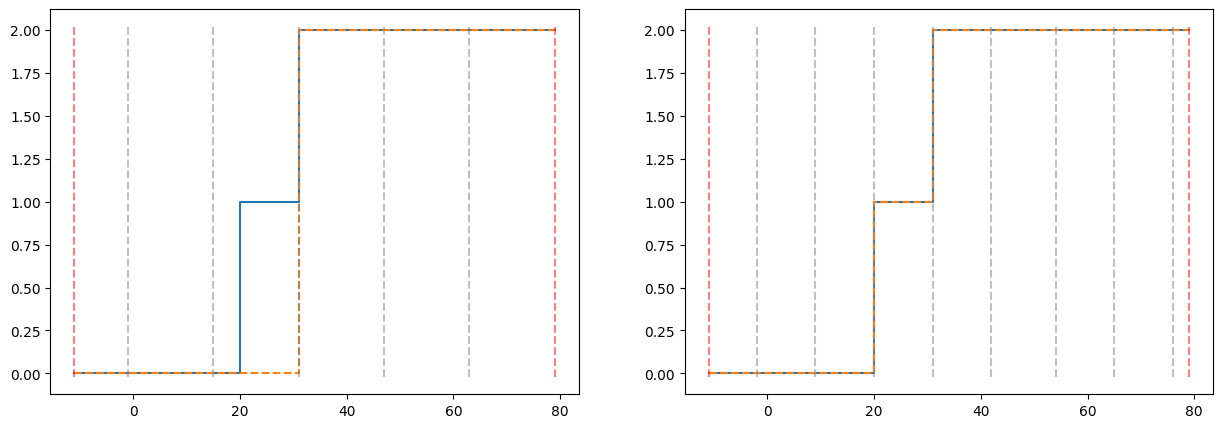

MINIMUM n-bits-rounding: 4
acc size 8
TLU output bit width 2
-1 87
n_parts=8.0, n_round=3
0 0
DEBUG:  3.169925001442312
x_delta_min-middle=-44.0, x_delta_max-middle=44.0
x_delta_min=-1, x_delta_max=87
a_prime=95325, b_prime=48.5
a_prime=95325, b_prime=48
acc size a b 24
lsbs_a_b=20
rounded values a b [11 11 11 11 11 11 11]


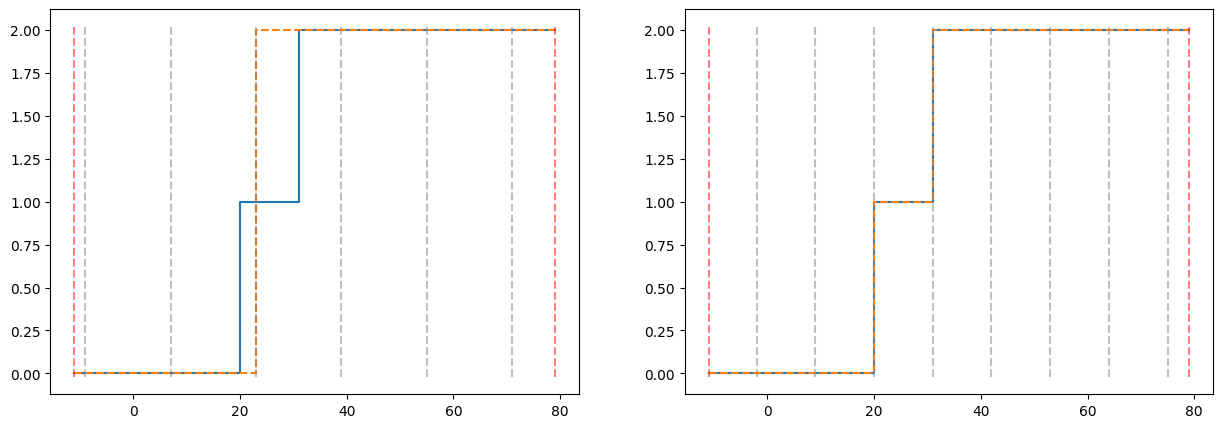

In [397]:
%reset
# Imports
from concrete.fhe import round_bit_pattern, truncate_bit_pattern
import numpy as np
from concrete.fhe.dtypes import Integer
import matplotlib.pyplot as plt

mult_first = False
if mult_first:    
    def linear_up_scaling(x: np.ndarray, a=1, b=0):
        assert x.dtype == np.int64
        assert isinstance(a, (int, np.int64)), f"{a=}, {type(a)=}"
        assert isinstance(b, (int, np.int64)), f"{b=}, {type(b)=}"
        return (x * a) + b
        
    def linear_down_scaling(x:np.ndarray, a=1, b=0):
        return (x.astype(np.float64) - float(b)) / float(a)
else:
    def linear_up_scaling(x: np.ndarray, a=1, b=0):
        assert x.dtype == np.int64
        assert isinstance(a, (int, np.int64)), f"{a=}, {type(a)=}"
        assert isinstance(b, (int, np.int64)), f"{b=}, {type(b)=}"
        return (x - b) * a
        
    def linear_down_scaling(x:np.ndarray, a=1, b=0):
        return (x.astype(np.float64) / float(a)) + float(b)

# Hypothesis:
# * all steps are the same size
# * they aren't too many of them

# Some parameters
# We could do a linear/binary search on the n-round-bits to use

# Function thresholds
step_size = 11  # Constant step size assumption
th1 = 21  # First threshold
th2 = th1 + step_size
th3 = th2 + step_size

thresholds = (th1, th2,)
# Function definition bounds
a, b = -11, 79

# Step size function to optimize
def f(x, thresholds=thresholds):
    res = np.zeros_like(x)
    for threshold in thresholds:
        res += (x >= threshold).astype(np.int64)
    return res

for rounding_function in [truncate_bit_pattern, round_bit_pattern]:
    # Comparison figure
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    
    # Minimum n-bits required
    rounding_threshold = int(np.ceil(np.log2((b-a)/step_size)))
    
    print("MINIMUM n-bits-rounding:", rounding_threshold)
    
    # Inputs
    x = np.arange(a, b+1, 1)  # Inputs
    x_acc_size = Integer.that_can_represent(x).bit_width
    print("acc size", x_acc_size)
    
    # Naive rounding baseline
    lsbs = x_acc_size - rounding_threshold
    x_rounded = rounding_function(x, lsbs)
    y = f(x)
    y_rounded = f(x_rounded)
    y_bit_width = Integer.that_can_represent(y).bit_width
    print("TLU output bit width", y_bit_width)
    
    # Plot baseline
    ax = axes[0]
    ax.step(x, y)
    ax.step(x, y_rounded, linestyle="dashed")
    # Add brackets to indicate inclusion

    
        #inclusion_marker = 'o' if y[i] == 1 else 'x'
        #ax.scatter(x[i], y[i], marker=inclusion_marker, color='b', s=100)

    delta_y = y.max() - y.min()
    epsilon_y = 0.01 * delta_y
    ax.vlines(
        x[np.concatenate([np.diff(x_rounded).astype(bool), [False]])],
        y.min()-epsilon_y, y.max()+epsilon_y, color="grey", linestyle="dashed", alpha=.5
    )
    ax.vlines(
        [a, b],
        y.min()-epsilon_y, y.max()+epsilon_y, color="red", linestyle="dashed", alpha=.5, label="data bounds",
    )

    # Find optimal a and b
    delta = step_size

    # Find new limits such that we have smallest bounds that include actual bounds as t_0 + (k * step_size)
    x_delta_min = th1 - ((th1 - a) // step_size ) * step_size - bool(a % step_size)*step_size
    x_delta_max = th1 + ((b - th1) // step_size ) * step_size + bool(b % step_size)*step_size

    print(x_delta_min, x_delta_max)
    
    # Number of elements in the new range for the given step size
    n_parts = ((x_delta_max - x_delta_min) / delta)
    n_round = np.ceil(np.log2(n_parts)).astype(np.int64)
    assert n_round <= rounding_threshold, f"{n_round=} > {rounding_threshold=}"
    print(f"{n_parts=}, {n_round=}")
    
    exceed = ((2**n_round)) - n_parts
    left_bound_add = np.ceil(exceed/2).astype(np.int64)
    right_bound_add = np.floor(exceed/2).astype(np.int64)
    assert left_bound_add + right_bound_add == exceed
    print(left_bound_add, right_bound_add)

    x_delta_min -= left_bound_add * step_size
    x_delta_max += right_bound_add * step_size
    print("DEBUG: ", np.log2(((x_delta_max - x_delta_min) / step_size)+1))

    middle = (x_delta_max - x_delta_min)/2
    middle = np.median(np.arange(x_delta_min, x_delta_max+1, step_size))
    print(f"{x_delta_min-middle=}, {x_delta_max-middle=}")
    print(f"{x_delta_min=}, {x_delta_max=}")

    if mult_first:
        n = x_acc_size
        n = 64
        a_prime = ((2**n) - step_size)/(x_delta_max - x_delta_min)

        b_prime = -2**(n-1) - (x_delta_min * ((2**n - 1)/(x_delta_max - x_delta_min)))
        
        print(f"{a_prime=}, {b_prime=}")
        
        a_prime = np.floor(a_prime).astype(np.int64)
        b_prime = np.floor(b_prime).astype(np.int64)
    else:
        n = x_acc_size
        n = 23
        a_prime = (2**n - 1) / (x_delta_max - x_delta_min)
        a_prime = np.floor(a_prime).astype(np.int64)

        # b_prime = (2**(n-1)) + (x_delta_min * a_prime)
        b_prime = middle
        if rounding_function == round_bit_pattern:
            b_prime += (delta/2)
        else:
            b_prime += 0
        print(f"{a_prime=}, {b_prime=}")

        a_prime = np.floor(a_prime).astype(np.int64)
        b_prime = np.floor(b_prime).astype(np.int64)

    print(f"{a_prime=}, {b_prime=}")

    
    # Evaluation with calibrated values
    x_a_b = linear_up_scaling(x, a=a_prime, b=b_prime)
    acc_a_b = Integer.that_can_represent(x_a_b).bit_width
    print("acc size a b", acc_a_b)
    lsbs_a_b = int(acc_a_b - rounding_threshold)
    print(f"{lsbs_a_b=}")
    x_a_b_rounded = linear_down_scaling(
        rounding_function(x_a_b, lsbs_a_b).astype(np.float64),
        b=float(b_prime)+1, a=float(a_prime)
    )
    print("rounded values a b", np.diff(x[np.concatenate([np.diff(x_a_b_rounded).astype(bool), [False]])]))
    y_calib_rounded = f(x_a_b_rounded)
    
    # Plot
    ax = axes[1]
    ax.step(x, y)
    ax.step(x, y_calib_rounded, linestyle="dashed")
    ax.vlines(x[np.concatenate([np.diff(x_a_b_rounded).astype(bool), [False]])], y.min()-epsilon_y, y.max()+epsilon_y, color="grey", linestyle="dashed", alpha=.5)
    ax.vlines(
        [a, b],
        y.min()-epsilon_y, y.max()+epsilon_y, color="red", linestyle="dashed", alpha=.5, label="data bounds",
    )
    
    # ax.vlines(
    #     [new_a, new_b],
    #     y.min()-epsilon_y, y.max()+epsilon_y, color="green", linestyle="dashed", alpha=.5, label="new artifical bounds",
    # )
    assert (y == y_calib_rounded).all()
    plt.show()
    plt.close(fig)

True

In [320]:
x = 5
y = 7
a = y/x
print(a)
a_int = np.floor(a)
print(a_int)
res = x * a_int
print(res)
res = res / a_int
print(res)

1.4
1.0
5.0
5.0


In [318]:
a_int

2.0

In [234]:
(new_b - new_a) / 2

49.0

8


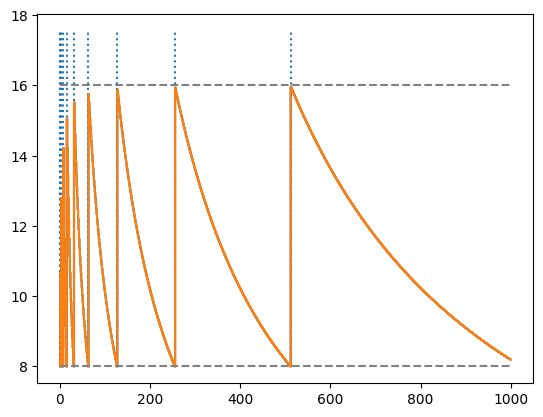

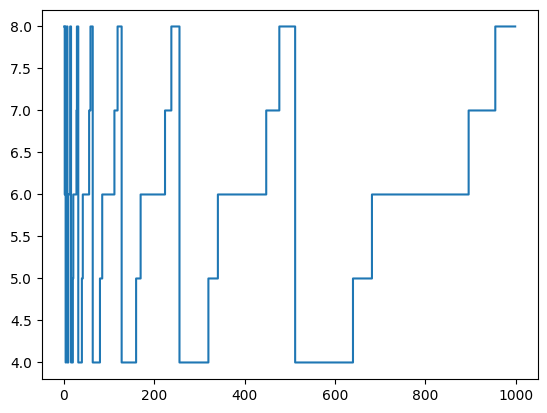

In [193]:
round_to = 3

if True:
    # Full n-bits range
    n_bits = 6
    min_value, max_value = -2**(n_bits-1), 2**(n_bits-1)-1
    assert n_bits == Integer.that_can_represent([min_value, max_value]).bit_width
else:
    # Manual range, not taking the full n-bits into account
    min_value, max_value = -20, 80
    n_bits = Integer.that_can_represent([min_value, max_value]).bit_width

sub_div_limit = 2 **(n_bits - round_to)
print(sub_div_limit)

x = np.arange(min_value, max_value)
subset_size = []
step_size = []
a_max = 1_000

for a in range(1, a_max):
    x_a = x*a
    x_a_acc_size = Integer.that_can_represent(x_a).bit_width
    lsbs = x_a_acc_size - round_to
    x_a_round = round_bit_pattern(x_a, lsbs).astype(np.float64) / a
    
    diff = np.diff(x_a_round)
    diff = diff[diff>0]
    assert np.isclose(diff, diff.max()).all(), diff
    step_size.append(diff.max())
    subset_size.append(len(diff)) 

    # fig, ax = plt.subplots()
    # ax.vlines(x_a_round, -1, 1, )
    # ax.set_xlim(min_value, max_value)
    # plt.show(fig)
    # plt.close(fig)

plt.step(list(range(1, a_max)), step_size)

for i in range(int(np.ceil(np.log2(a_max)))):
    plt.vlines(2**i, min(step_size), max(step_size)*1.1, linestyle="dotted")
    
plt.step(list(range(1, a_max)), step_size)
# These bounds are only true if scaled to [-2**(n-1)+1, 2**(n-1)-1]
plt.hlines(sub_div_limit, 1, a_max, linestyle="dashed", color="grey")
plt.hlines(2*sub_div_limit, 1, a_max, linestyle="dashed", color="grey")
plt.show() 
plt.close()

plt.step(list(range(1, a_max)), subset_size)

9.0

In [42]:
(x_rounded==0).sum(), (y_rounded==0).sum()

(43, 43)

array([42])

In [ ]:
# Snippet to dump all variables
# import shelve
# import sys
# from dill import Pickler, Unpickler
# shelve.Pickler = Pickler
# shelve.Unpickler = Unpickler

# filename='/tmp/shelve.out'
# my_shelf = shelve.open(filename,'n') # 'n' for new
# for key in dir():
#     try:
#         if key in globals():
#             my_shelf[key] = globals()[key]
#         if key in locals():
#             my_shelf[key] = locals()[key]
#     except Exception:
#         print('ERROR shelving: {0}'.format(key))
# my_shelf.close()
# sys.exit(0)

In [42]:
rounding_threshold = 3

In [43]:
import numpy as np
from concrete.fhe.dtypes import Integer
from concrete.fhe import round_bit_pattern
from concrete.ml.common.preprocessors import vectorized_graph_eval

best_a = np.ones_like(subgraph_inputs)
best_b = np.zeros_like(subgraph_inputs)
x = (subgraph_inputs + best_b) * best_a
accumulator_bit_width = Integer.that_can_represent(x).bit_width
lsbs_to_remove = (
    accumulator_bit_width - rounding_threshold
)
if lsbs_to_remove > 0:
    x = round_bit_pattern(x, lsbs_to_remove=lsbs_to_remove)
    
assert isinstance(x, np.ndarray)
print("acc-size after rounding", Integer.that_can_represent(x).bit_width)

x = (x.astype(np.float64) / best_a.astype(np.float64)) - best_b.astype(np.float64)
approximated_no_calib = vectorized_graph_eval(
    tlu_subgraph,
    x,
)

acc-size after rounding 10


In [44]:
best_a = np.ones_like(subgraph_inputs)
best_b = np.zeros_like(subgraph_inputs)+100
x = (subgraph_inputs + best_b) * best_a
accumulator_bit_width = Integer.that_can_represent(x).bit_width
lsbs_to_remove = (
    accumulator_bit_width - rounding_threshold
)
if lsbs_to_remove > 0:
    x = round_bit_pattern(x, lsbs_to_remove=lsbs_to_remove)
    
assert isinstance(x, np.ndarray)
print("acc-size after rounding", Integer.that_can_represent(x).bit_width)
x = (x.astype(np.float64) / best_a.astype(np.float64)) - best_b.astype(np.float64)
approximated_calib = vectorized_graph_eval(
    tlu_subgraph,
    x,
)

acc-size after rounding 9


In [47]:
from sklearn.linear_model import LinearRegression

In [53]:
model = LinearRegression()
model.fit(X=subgraph_inputs[:, 0:1], y=reference[:, 0])

LinearRegression()

In [55]:
model.coef_, model.intercept_

(array([0.65894174]), 56.454999602469925)

In [ ]:
# This last TLU probably needs a lot of bit-width, decreasing the bit-width of it fucks us up
# We probably shouldn't try to optimize this last one
# We could maybe have something that does a {tlu-output-bit-width -> rounding-n-bit}

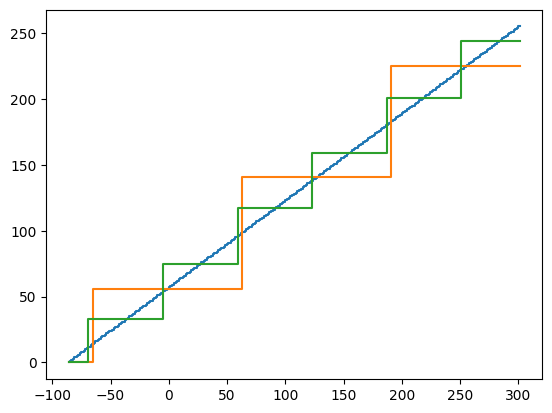

In [45]:
import matplotlib.pyplot as plt
plt.step(subgraph_inputs[:, 0], reference[:, 0])
plt.step(subgraph_inputs[:, 0], approximated_no_calib[:, 0])
plt.step(subgraph_inputs[:, 0], approximated_calib[:, 0])

In [23]:
# This TLU is really weird to me
# We should probably detect if a TLU only applies a linear transformation on the bounds
print(tlu_subgraph.format())

 %0 = input                            # EncryptedTensor<uint10, shape=(1, 10)>                 @ /linear_features.6/MatMul.matmul
 %1 = astype(%0, dtype=float64)        # EncryptedTensor<float64, shape=(1, 10)>                @ /linear_features.6/MatMul.matmul_rounding
 %2 = 0                                # ClearScalar<uint1>
 %3 = add(%1, %2)                      # EncryptedTensor<float64, shape=(1, 10)>
 %4 = [[0 0 0 0 0 0 0 0 0 0]]          # ClearTensor<uint1, shape=(1, 10)>
 %5 = subtract(%3, %4)                 # EncryptedTensor<float64, shape=(1, 10)>
 %6 = 1.0                              # ClearScalar<float64>
 %7 = multiply(%6, %5)                 # EncryptedTensor<float64, shape=(1, 10)>
 %8 = [-16.515297]                     # ClearTensor<float32, shape=(1,)>
 %9 = add(%7, %8)                      # EncryptedTensor<float64, shape=(1, 10)>
%10 = [85.65643311]                    # ClearTensor<float64, shape=(1,)>
%11 = divide(%9, %10)                  # EncryptedTensor<flo

In [7]:
list(locals().keys())

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__builtin__',
 '__builtins__',
 '_ih',
 '_oh',
 '_dh',
 'In',
 'Out',
 'get_ipython',
 'exit',
 'quit',
 'open',
 '_',
 '__',
 '___',
 '__session__',
 '_i',
 '_ii',
 '_iii',
 '_i1',
 'shelve',
 'filename',
 '_i2',
 'my_shelf',
 'key',
 'all_node_inputs',
 'pred_node',
 'shape_',
 'tlu_subgraph',
 'all_nodes_results',
 'expected_shape',
 'graph',
 'pred_nodes',
 'variable_input_indices',
 'tlu_index',
 'variable_input_index',
 'Unpickler',
 'constant_shapes',
 'elt',
 'max_bound',
 'tlu_nodes',
 'subgraph_inputs',
 'reference',
 'sys',
 'reduce_axes',
 'sorted_nodes',
 'Pickler',
 'constant_shape',
 'self',
 'tlu_node',
 'variable_input_node',
 'min_bound',
 'subgraph_input_shape',
 '_i3',
 '_3',
 '_i4',
 '_4',
 '_i5',
 '_i6',
 '_6',
 '_i7']